In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunalkalashii","key":"d71d65239ecc151393eb1d78159597f6"}'}

In [2]:
!mkdir ~/.kaggle/

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:08<00:00, 172MB/s]
100% 812M/812M [00:08<00:00, 95.5MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip

In [8]:

!unzip -qq train.zip

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Since the model might overfit, we use the regularization technique during the DATA PREPROCESSING stage. Here, every image has been converted into a tensor.

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Callback can be used to stop training early if the model is not progressing, or to store the model's weights at the end of each epoch. Callbacks can also be used to schedule changes in learning rate, log metrics, and visualize the model's performance.


In [15]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.x",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 14s 138ms/step - loss: 0.6977 - accuracy: 0.5290 - val_loss: 0.7003 - val_accuracy: 0.5040
Epoch 2/10
63/63 [==============================] - 5s 73ms/step - loss: 0.6843 - accuracy: 0.5600 - val_loss: 0.6561 - val_accuracy: 0.6220
Epoch 3/10
63/63 [==============================] - 5s 73ms/step - loss: 0.6503 - accuracy: 0.6160 - val_loss: 0.6400 - val_accuracy: 0.6120
Epoch 4/10
63/63 [==============================] - 8s 119ms/step - loss: 0.6153 - accuracy: 0.6635 - val_loss: 0.6086 - val_accuracy: 0.6570
Epoch 5/10
63/63 [==============================] - 4s 58ms/step - loss: 0.5818 - accuracy: 0.6905 - val_loss: 1.0827 - val_accuracy: 0.5270
Epoch 6/10
63/63 [==============================] - 5s 71ms/step - loss: 0.5644 - accuracy: 0.7120 - val_loss: 0.5660 - val_accuracy: 0.7150
Epoch 7/10
63/63 [==============================] - 7s 102ms/step - loss: 0.5306 - accuracy: 0.7310 - val_loss: 0.6639 - val_accuracy: 0.6560
Epoch 8/1

It can be shown that as the number of epochs increases, accuracy increases.

Accuracy=79.90% Val_acc=71.80% test accuracy=71.80%

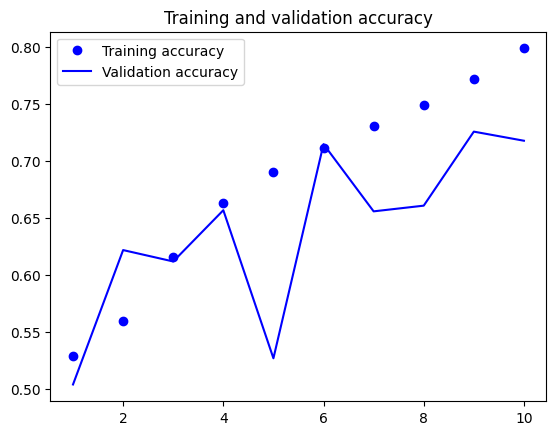

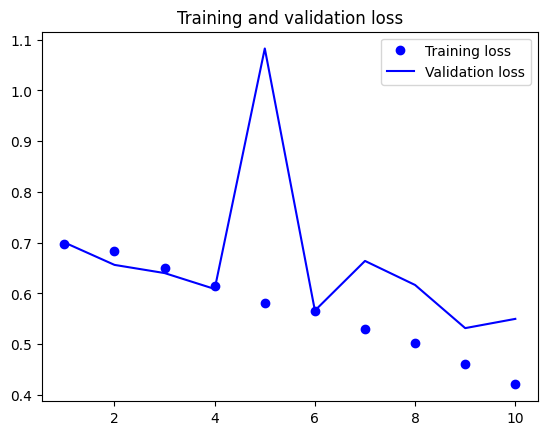

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
test_model = keras.models.load_model("convnet_from_scratch1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 42ms/step - loss: 0.5876 - accuracy: 0.7180
Test accuracy: 0.718


test accuracy without data augmentation=71.80%

**Data Augmentation**

In order to increase the size of a training set, "data augmentation" creates new, modified versions of the original data. By doing this, overfitting gets reduced and the model's ability to generalize is improved.



In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 10s 84ms/step - loss: 0.7057 - accuracy: 0.5120 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 7s 103ms/step - loss: 0.6953 - accuracy: 0.5335 - val_loss: 0.7657 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 4s 57ms/step - loss: 0.6904 - accuracy: 0.5430 - val_loss: 0.7429 - val_accuracy: 0.5140
Epoch 4/10
63/63 [==============================] - 7s 101ms/step - loss: 0.6741 - accuracy: 0.5800 - val_loss: 0.6429 - val_accuracy: 0.6270
Epoch 5/10
63/63 [==============================] - 8s 116ms/step - loss: 0.6553 - accuracy: 0.6115 - val_loss: 0.6196 - val_accuracy: 0.6530
Epoch 6/10
63/63 [==============================] - 4s 57ms/step - loss: 0.6262 - accuracy: 0.6625 - val_loss: 0.6520 - val_accuracy: 0.6010
Epoch 7/10
63/63 [==============================] - 7s 112ms/step - loss: 0.6010 - accuracy: 0.6695 - val_loss: 0.6330 - val_accuracy: 0.6510
Epoch 8/

In [21]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 27ms/step - loss: 0.6426 - accuracy: 0.6780
Test accuracy: 0.678


Accuracy=70.30% val_Acc=70.0% test_acc=67.8%

2) **Increase training sample size**

Tried by increasing training sample size from 1000 to 1500.

In [22]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [23]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 11s 100ms/step - loss: 0.6987 - accuracy: 0.5467 - val_loss: 0.6809 - val_accuracy: 0.5930
Epoch 2/10
94/94 [==============================] - 6s 62ms/step - loss: 0.6720 - accuracy: 0.5953 - val_loss: 0.6303 - val_accuracy: 0.6530
Epoch 3/10
94/94 [==============================] - 5s 50ms/step - loss: 0.6250 - accuracy: 0.6440 - val_loss: 0.6913 - val_accuracy: 0.6040
Epoch 4/10
94/94 [==============================] - 7s 70ms/step - loss: 0.5787 - accuracy: 0.7023 - val_loss: 0.6300 - val_accuracy: 0.6170
Epoch 5/10
94/94 [==============================] - 8s 83ms/step - loss: 0.5363 - accuracy: 0.7250 - val_loss: 0.5996 - val_accuracy: 0.6750
Epoch 6/10
94/94 [==============================] - 6s 59ms/step - loss: 0.5019 - accuracy: 0.7477 - val_loss: 0.5772 - val_accuracy: 0.7090
Epoch 7/10
94/94 [==============================] - 9s 91ms/step - loss: 0.4594 - accuracy: 0.7847 - val_loss: 0.5763 - val_accuracy: 0.7000
Epoch 8/10


In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.5250 - accuracy: 0.7620
Test accuracy: 0.762


Accuracy=86.03% val_acc=70.80% test_acc=76.2%

**Using data augmentation**

In [27]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 13s 104ms/step - loss: 0.6914 - accuracy: 0.5330 - val_loss: 0.6893 - val_accuracy: 0.5460
Epoch 2/10
94/94 [==============================] - 7s 69ms/step - loss: 0.6796 - accuracy: 0.5747 - val_loss: 0.6851 - val_accuracy: 0.5710
Epoch 3/10
94/94 [==============================] - 10s 105ms/step - loss: 0.6725 - accuracy: 0.5820 - val_loss: 0.6690 - val_accuracy: 0.5810
Epoch 4/10
94/94 [==============================] - 7s 73ms/step - loss: 0.6591 - accuracy: 0.6047 - val_loss: 0.6433 - val_accuracy: 0.6500
Epoch 5/10
94/94 [==============================] - 10s 107ms/step - loss: 0.6369 - accuracy: 0.6467 - val_loss: 0.6379 - val_accuracy: 0.6580
Epoch 6/10
94/94 [==============================] - 5s 53ms/step - loss: 0.6380 - accuracy: 0.6347 - val_loss: 0.6564 - val_accuracy: 0.6200
Epoch 7/10
94/94 [==============================] - 9s 86ms/step - loss: 0.6302 - accuracy: 0.6453 - val_loss: 0.6257 - val_accuracy: 0.6660
Epoch 8

In [30]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.5323 - accuracy: 0.7120
Test accuracy: 0.712


Accuracy=72.30% val_acc=72.0% test_acc=71.2%

**3.** **Finding the ideal training sample size**

We set the training, validation, and test set sizes, respectively, to 1500, 1000, and 500.

In [31]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [32]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [33]:

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [34]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 10s 77ms/step - loss: 0.6968 - accuracy: 0.5200 - val_loss: 0.6841 - val_accuracy: 0.5740
Epoch 2/10
94/94 [==============================] - 10s 102ms/step - loss: 0.6770 - accuracy: 0.6003 - val_loss: 0.6944 - val_accuracy: 0.6185
Epoch 3/10
94/94 [==============================] - 7s 73ms/step - loss: 0.6310 - accuracy: 0.6403 - val_loss: 0.6212 - val_accuracy: 0.6420
Epoch 4/10
94/94 [==============================] - 10s 109ms/step - loss: 0.5795 - accuracy: 0.6990 - val_loss: 0.6065 - val_accuracy: 0.6675
Epoch 5/10
94/94 [==============================] - 7s 70ms/step - loss: 0.5288 - accuracy: 0.7427 - val_loss: 0.5421 - val_accuracy: 0.7320
Epoch 6/10
94/94 [==============================] - 10s 107ms/step - loss: 0.4956 - accuracy: 0.7677 - val_loss: 0.6126 - val_accuracy: 0.7085
Epoch 7/10
94/94 [==============================] - 8s 81ms/step - loss: 0.4530 - accuracy: 0.7783 - val_loss: 0.6146 - val_accuracy: 0.6800
Epoch 

In [35]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 27ms/step - loss: 0.5786 - accuracy: 0.7130
Test accuracy: 0.713


In [36]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [37]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [38]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 9s 73ms/step - loss: 0.7054 - accuracy: 0.5353 - val_loss: 0.6954 - val_accuracy: 0.5070
Epoch 2/10
94/94 [==============================] - 9s 90ms/step - loss: 0.6796 - accuracy: 0.5827 - val_loss: 0.7244 - val_accuracy: 0.5185
Epoch 3/10
94/94 [==============================] - 7s 71ms/step - loss: 0.6428 - accuracy: 0.6400 - val_loss: 0.6814 - val_accuracy: 0.5890
Epoch 4/10
94/94 [==============================] - 10s 107ms/step - loss: 0.6082 - accuracy: 0.6707 - val_loss: 0.6057 - val_accuracy: 0.6710
Epoch 5/10
94/94 [==============================] - 6s 61ms/step - loss: 0.5541 - accuracy: 0.7160 - val_loss: 0.6138 - val_accuracy: 0.6600
Epoch 6/10
94/94 [==============================] - 9s 92ms/step - loss: 0.5129 - accuracy: 0.7580 - val_loss: 0.5395 - val_accuracy: 0.7275
Epoch 7/10
94/94 [==============================] - 7s 71ms/step - loss: 0.4810 - accuracy: 0.7743 - val_loss: 0.5697 - val_accuracy: 0.7410
Epoch 8/10


In [40]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 42ms/step - loss: 0.5709 - accuracy: 0.7220
Test accuracy: 0.722


Accuracy=84.87% val_Acc=74.9% test_Acc=72.22%

**Using Data augmentation**

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


In [42]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 13s 108ms/step - loss: 0.6938 - accuracy: 0.5113 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 11s 115ms/step - loss: 0.6946 - accuracy: 0.4900 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/10
94/94 [==============================] - 7s 67ms/step - loss: 0.6935 - accuracy: 0.4997 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/10
94/94 [==============================] - 7s 68ms/step - loss: 0.6940 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
94/94 [==============================] - 8s 86ms/step - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
94/94 [==============================] - 6s 62ms/step - loss: 0.6933 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
94/94 [==============================] - 7s 71ms/step - loss: 0.6936 - accuracy: 0.4897 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 8/1

In [44]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.6929 - accuracy: 0.5000
Test accuracy: 0.500


Accuracy=49.67% val_acc=50% test_acc=50%

**4.Using a pre-trained network**

VGG16 is the architecture of this pre-trained network.

Feature extraction - Instantiating the VGG16 convolutional base

In [45]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [46]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 2s 2s/step


(3000, 5, 5, 512)

Feature extraction is the process of defining and training a highly connected classifier.



In [47]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 2s 14ms/step - loss: 10.0792 - accuracy: 0.9387 - val_loss: 2.0239 - val_accuracy: 0.9785
Epoch 2/15
94/94 [==============================] - 1s 5ms/step - loss: 2.6510 - accuracy: 0.9790 - val_loss: 3.6787 - val_accuracy: 0.9725
Epoch 3/15
94/94 [==============================] - 0s 5ms/step - loss: 1.7233 - accuracy: 0.9857 - val_loss: 6.2140 - val_accuracy: 0.9720
Epoch 4/15
94/94 [==============================] - 0s 5ms/step - loss: 1.2855 - accuracy: 0.9897 - val_loss: 4.4806 - val_accuracy: 0.9740
Epoch 5/15
94/94 [==============================] - 0s 5ms/step - loss: 1.1416 - accuracy: 0.9930 - val_loss: 5.2547 - val_accuracy: 0.9720
Epoch 6/15
94/94 [==============================] - 1s 6ms/step - loss: 0.7380 - accuracy: 0.9933 - val_loss: 6.1025 - val_accuracy: 0.9740
Epoch 7/15
94/94 [==============================] - 0s 5ms/step - loss: 0.3606 - accuracy: 0.9967 - val_loss: 4.5252 - val_accuracy: 0.9740
Epoch 8/15
94/94 [

accuracy=99.8% val_acc=96.6%

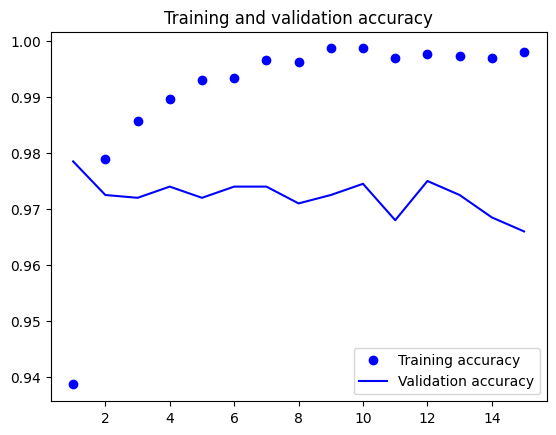

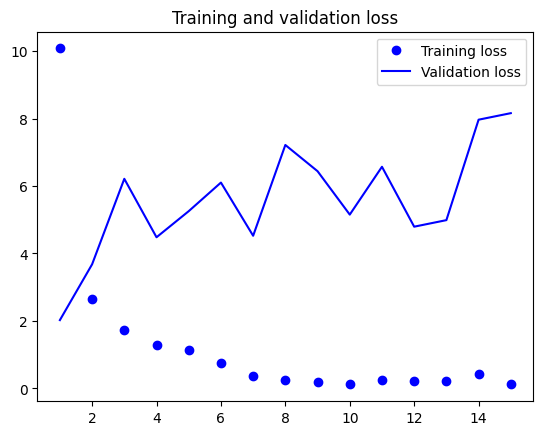

In [48]:

import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [49]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Feature extraction with Data Augmentation**

In [50]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [52]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
94/94 [==============================] - 20s 190ms/step - loss: 15.5152 - accuracy: 0.9077 - val_loss: 3.1959 - val_accuracy: 0.9730
Epoch 2/5
94/94 [==============================] - 15s 158ms/step - loss: 6.8777 - accuracy: 0.9523 - val_loss: 3.3988 - val_accuracy: 0.9755
Epoch 3/5
94/94 [==============================] - 18s 190ms/step - loss: 5.5117 - accuracy: 0.9580 - val_loss: 2.9788 - val_accuracy: 0.9775
Epoch 4/5
94/94 [==============================] - 16s 163ms/step - loss: 5.4985 - accuracy: 0.9580 - val_loss: 8.4787 - val_accuracy: 0.9560
Epoch 5/5
94/94 [==============================] - 20s 206ms/step - loss: 3.9483 - accuracy: 0.9687 - val_loss: 5.3347 - val_accuracy: 0.9715


In [53]:

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 89ms/step - loss: 5.0511 - accuracy: 0.9730
Test accuracy: 0.973


Accuracy=96.87% val_Acc=97.15% test_acc=97.3%